errL12 CF = 0.00304857 errL12 UPW = 0.000273272
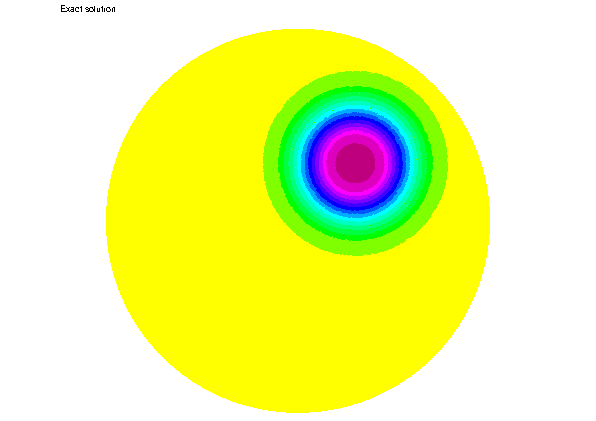
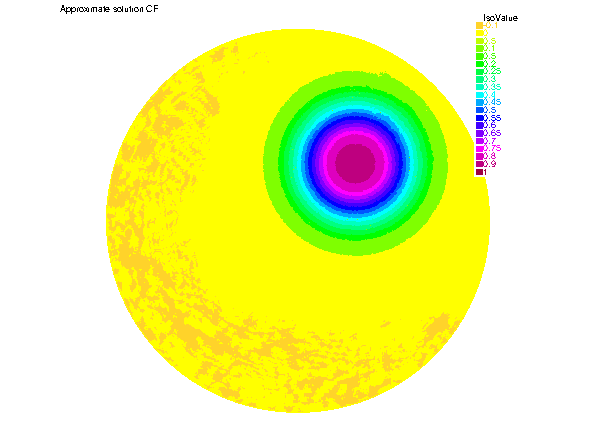
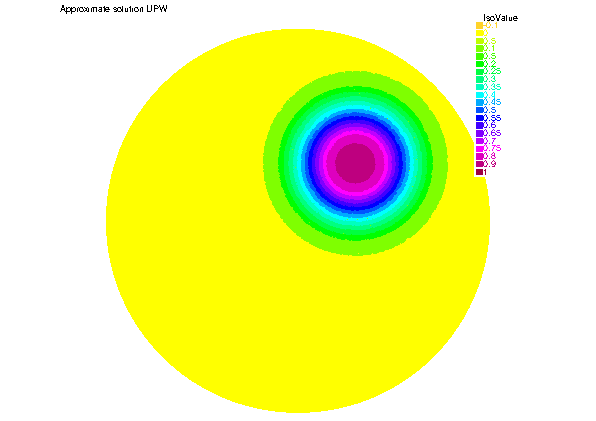

In [1]:
// Problem (P):
// b \cdot \grad u + \mu \cdot u = f   en \Omega,
// u = 0   sobre \partial\Omega^- = \{ x \in \partial\Omega, b(x)\cdot n(x) <0 \}
//
// We take:
//   * \Omega= unit circle,
//   * b(x1,x2) = [x2, -x1], then \Omega^- = empty
//   * mu = 2A, A=10, x0=0.3, y0=0.3 (e.g.)
//   * Then u(x,y) = exp( -A*( (x-x0)^2 + (y-y0)^2 ) )  is an exact solution of
//     problem (P) with mu = 2*A and f(x,y) = -2*A(x*y0 - x0*y - 1)*u


// Mesh and finite element spaces
border Gamma(t=0, 2*pi) { x=cos(t);  y=sin(t); };
mesh Th = buildmesh(Gamma(280));

fespace Uh(Th, P1dc);
Uh u, ub; // Unknown and test function
Uh b1 = y, b2 = -x;
macro b() [b1, b2] // EOM

// Exact solution
real A=10, x0=0.3, y0=0.3;
real mu=2*A;
func uExac = exp( -A*( (x-x0)^2 + (y-y0)^2 ) );
func f = -2*A*(x*y0 - x0*y - 1)*uExac(x,y);

// Numerical approximation parameters
real eta = 1;

// Plot exact solution...
u = uExac;
real [int] viso=[-0.1,0,0.5,0.1,0.5,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.9,1];
plot(u, fill=1, wait=1, viso=viso, cmm="Exact solution");

// Macros..........................................................................
macro grad(u) [dx(u), dy(u) ] // EOM
  ; // for emacs
macro dot(u,v) ( u[0]*v[0] + u[1]*v[1] ) // EOM
; // for emacs
macro dotN(u) dot(u, [N.x, N.y]) // EOM
  ; // for emacs
macro pos(u) (0.5*(abs(u)+u)) // Postivie part
  ; // for emacs
macro neg(u) (0.5*(abs(u)-u)) // Negative part
  ; // for emacs
macro intInteriorEdges(expr) ( intalledges(Th)((nTonEdge-1)*(expr)) ) // EOM
  ; // for emacs
//................................................................................


// ------------------------------------------------------------------------------------
// Centered fluxes approximation
// ====================================================================================
problem ConvectReactCF(u,ub)=
  int2d(Th)( dot(b, grad(u)) * ub // Convection term
	     + mu * u*ub // Reaction term
	     )
	     //  - int1d(Th,C)(neg(dotN(b))*u*ub)  // unused because cc=0 on d(Omega)^-
  - intInteriorEdges(dotN(b) * (-jump(u)) * mean(ub) )
  - int2d(Th)( f(x,y)*ub );
// ------------------------------------------------------------------------------------

// ------------------------------------------------------------------------------------
// Upwind fluxes approximation
// ====================================================================================
problem ConvectReactUPW(u,ub)=
  int2d(Th)( dot(b, grad(u)) * ub // Convection term
	     + mu * u*ub // Reaction term
	     )
	     //  - int1d(Th,C)(neg(dotN(b))*u*ub)  // unused because cc=0 on d(Omega)^-
  - intInteriorEdges(dotN(b) * (-jump(u)) * mean(ub) )
  + intInteriorEdges(eta/2 * abs(dotN(b)) * jump(u)*jump(ub) )
  - int2d(Th)( f(x,y)*ub );
// ------------------------------------------------------------------------------------

// // Problem taken from FreeFem++ doc
// macro n()(N.x*b1+N.y*b2) //
// problem  Adual(u,ub) = int2d(Th)((mu*u+(b1*dx(u)+b2*dy(u)))*ub)
//   + intalledges(Th)((1-nTonEdge)*ub*(0.5*abs(n)-n/2)*jump(u))
// //  - int1d(Th,C)((n(u)<0)*abs(n(u))*cc*w)  // unused because cc=0 on d(Omega)^-
//   - int2d(Th)(f*ub);

// Solve problem with centered fluxes
ConvectReactCF;
plot(u, fill=1, wait=1, value=1, viso=viso, cmm="Approximate solution CF");
ub = u - uExac;
real errL2CF = sqrt(int2d(Th)(ub*ub));
cout << "errL12 CF = " << errL2CF << endl;

// Solve problem with upwind fluxes
ConvectReactUPW;
plot(u, fill=1, wait=1, value=1, viso=viso, cmm="Approximate solution UPW");
ub = u - uExac;
real errL2UPW = sqrt(int2d(Th)(ub*ub));
cout << "errL12 UPW = " << errL2UPW << endl;
// plot(ub, fill=1, wait=1, value=1, viso=viso, cmm="Error");